# Requeriments

# Libraries

In [38]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#Spark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover

from pyspark.sql.functions import *
from pyspark.sql.functions import from_utc_timestamp, udf, array_distinct, col, when
from pyspark.sql.functions import regexp_replace, year, month, dayofmonth, hour, format_string
from pyspark.sql.functions import monotonically_increasing_id

#Sentiment Analyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Hadoop
from hdfs import InsecureClient

### Imports with downloads

This section is seperate just to prevent re-donwload the libraries which time a new library is add.

### Warnings conf

In this sections the warnings are suppressed, less logs while running the code

In [2]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

# Data Loading

## Reading Data from Hadoop

In this section we are reading data from Hadoop, using a Spark Session.

### Spark configurations and Connection

In [3]:
def spark_start(restart = False, appname="HadoopAccess"):

    if restart == True:
        spark.stop()
    
    # Configuration parameters for Spark
    spark_conf = SparkConf().setMaster("local[*]").setAppName(appname)

    # Using SparkSession
    spark = SparkSession.builder.config(conf=spark_conf).config('spark.sql.session.timeZone', 'UTC').getOrCreate()
    
     # this will help not to have too much error displaying
    sc = spark.sparkContext
    sc.setLogLevel('ERROR')
    
    return spark


spark = spark_start()


2023-05-11 23:49:16,601 WARN util.Utils: Your hostname, BDS-2023 resolves to a loopback address: 127.0.1.1; using 192.168.0.110 instead (on interface wlo1)
2023-05-11 23:49:16,602 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-05-11 23:49:17,487 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Tweets Dataset

This dataset was collect from Internet Archive, processed and stored on hadoop, following the Collect Jupyter Notebook

In [4]:
#Reading all parquets file in the folder tweets on Hadoop
tweets = spark.read.parquet("/CA4/tweets/*.parquet")

#selecting just the columns wich we'll use in this analyse
tweets = tweets.select("created_at", "month", "text", "entities")

#setting the column created_at as timestamp
tweets = tweets.withColumn("created_at", from_utc_timestamp(tweets["created_at"], "UTC"))
tweets.show(truncate=True, n=3)

+-------------------+-----+--------------------+--------------------+
|         created_at|month|                text|            entities|
+-------------------+-----+--------------------+--------------------+
|2022-01-01 23:51:54|    1|RT @ampahcd: @Zac...|"{\"hashtags\": [...|
|2022-01-01 23:41:24|    1|RT @Rina_The_Espe...|"{\"hashtags\": [...|
|2022-01-01 23:41:28|    1|@VVitchStreams @R...|"{\"hashtags\": [...|
+-------------------+-----+--------------------+--------------------+
only showing top 3 rows



#### Exploring tweets Dataset

In [5]:
tweets.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- month: long (nullable = true)
 |-- text: string (nullable = true)
 |-- entities: string (nullable = true)



In [6]:
#as shown in the summary the dataframe has 763.266 lines
tweets.summary().show()

+-------+-----------------+--------------------+--------------------+
|summary|            month|                text|            entities|
+-------+-----------------+--------------------+--------------------+
|  count|           763266|              763266|              763266|
|   mean|6.986469985562045|                null|                null|
| stddev|4.225819505260059|                null|                null|
|    min|                1|!\nNew big data s...|"{\"hashtags\": [...|
|    25%|                2|                null|                null|
|    50%|                7|                null|                null|
|    75%|               11|                null|                null|
|    max|               12|🫰💰💵\n\nRT @OAN...|{"urls": [{"url":...|
+-------+-----------------+--------------------+--------------------+



In [7]:
#checking the distribution of tweets by month
df = tweets.groupBy(year("created_at").alias("year"), month("created_at").alias("month")).count() \
                                 .orderBy(["year", "month"])
#getting percentage
df.withColumn("percentage", format_string("%.2f%%",((df["count"]/tweets.count())*100))).show()

+----+-----+------+----------+
|year|month| count|percentage|
+----+-----+------+----------+
|2021|   11|130286|    17.07%|
|2021|   12|144352|    18.91%|
|2022|    1|127260|    16.67%|
|2022|    2| 67213|     8.81%|
|2022|    3| 40585|     5.32%|
|2022|    4| 31546|     4.13%|
|2022|    5| 39132|     5.13%|
|2022|    6| 38449|     5.04%|
|2022|    7| 41471|     5.43%|
|2022|    8| 32139|     4.21%|
|2022|    9| 24553|     3.22%|
|2022|   10| 46280|     6.06%|
+----+-----+------+----------+



### Training Dataset

Our model will be trained using a Dataset provided by user ardianumam on [Github](https://github.com/ardianumam/compilations/blob/master/ApacheSparkVideoSeries/dataset/README.md)

In [8]:
#read csv file
tweets_train = spark.read.csv('/CA4/tweets/training_database/tweets.csv', inferSchema=True, header=True)
tweets_train = tweets_train.select(col("SentimentText").alias("text"), col("Sentiment").cast("Int").alias("label"))
tweets_train.show(n=3)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|that film is fant...|    1|
|this music is rea...|    1|
|winter is terribl...|    0|
+--------------------+-----+
only showing top 3 rows



#### Exploring training dataset

In [9]:
tweets_train.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [10]:
tweets_train.summary().show()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|                1932|               1932|
|   mean|                null|0.49585921325051757|
| stddev|                null|  0.500112298992253|
|    min|I adore cheese #b...|                  0|
|    25%|                null|                  0|
|    50%|                null|                  0|
|    75%|                null|                  1|
|    max|winter is the bes...|                  1|
+-------+--------------------+-------------------+



In [11]:
df = tweets_train.groupBy("label").count()

#getting percentage
df.withColumn("percentage", format_string("%.2f%%",((df["count"]/tweets_train.count())*100))).show()

print("Positive = 1")
print("Negative = 2")

+-----+-----+----------+
|label|count|percentage|
+-----+-----+----------+
|    1|  958|    49.59%|
|    0|  974|    50.41%|
+-----+-----+----------+

Positive = 1
Negative = 2


# Sentiment Analysis

## Logistic Regression Classifier Model

Following the steps of the [tutorial](https://github.com/ardianumam/compilations/blob/master/ApacheSparkVideoSeries/08%20Sentiment%20Analysis%20in%20Spark.ipynb)

### Training Dataset

#### Dividing data

In [12]:
#80% training, 20% testing
dividedData = tweets_train.randomSplit([0.8, 0.2]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
print ("Training:", trainingData.count(), "\nTesting:", testingData.count())

Training: 1567 
Testing: 365


#### Preparing Training Data

In [13]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenizedTrain = tokenizer.transform(trainingData)


swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)


hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")  
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')

numericTrainData.show(n=3)

+-----+--------------------+--------------------+
|label|     MeaningfulWords|            features|
+-----+--------------------+--------------------+
|    1|[adore, cheese, #...|(262144,[1689,910...|
|    1|[adore, cheese, #...|(262144,[1689,453...|
|    1|[adore, cheese, #...|(262144,[1689,100...|
+-----+--------------------+--------------------+
only showing top 3 rows



#### Training the model

In [14]:
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

Training is done!


#### Preparing Testing data

In [15]:
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'Label', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)

+-----+-------------------------------------+-------------------------------------------------------+
|Label|MeaningfulWords                      |features                                               |
+-----+-------------------------------------+-------------------------------------------------------+
|1    |[adore, classical, music, #brilliant]|(262144,[45361,100089,102383,131250],[1.0,1.0,1.0,1.0])|
|1    |[adore, classical, music, #thumbs-up]|(262144,[88825,100089,102383,131250],[1.0,1.0,1.0,1.0])|
+-----+-------------------------------------+-------------------------------------------------------+
only showing top 2 rows



#### Predicting testing data

In [16]:
prediction = model.transform(numericTest)

predictionFinal = prediction.select(
    "MeaningfulWords", "prediction", "Label")

predictionFinal.show(n=4, truncate = False)

correctPrediction = predictionFinal.filter(predictionFinal['prediction'] == predictionFinal['Label']).count()

totalData = predictionFinal.count()

print("Correct prediction:", correctPrediction) 
print("Total data:", totalData)
print(f"Accuracy: {correctPrediction/totalData:.4}")

+-------------------------------------+----------+-----+
|MeaningfulWords                      |prediction|Label|
+-------------------------------------+----------+-----+
|[adore, classical, music, #brilliant]|1.0       |1    |
|[adore, classical, music, #thumbs-up]|1.0       |1    |
|[adore, coffee, #brilliant]          |1.0       |1    |
|[adore, coffee, #favorite]           |1.0       |1    |
+-------------------------------------+----------+-----+
only showing top 4 rows

Correct prediction: 363
Total data: 365
Accuracy: 0.9945


### Tweets Dataset

#### Cleaning Data

In [17]:
at_regex = r"@\w+" #Remove usernames
link_regex = r"http\S+" #Remove links
rt_regex = r'\bRT\b' #Remove 'RT'
ss_regex = r'[^\w\s]' #Remove Special strings
ds_regex = r'\s+' #remove spaces

tweets = tweets.withColumn("cleaned_text", regexp_replace("text", at_regex, "").alias("text_without_at_signs")) \
    .withColumn("cleaned_text", regexp_replace("cleaned_text", link_regex, "").alias("text_without_links")) \
    .withColumn("cleaned_text", regexp_replace("cleaned_text", rt_regex, "").alias("text_without_regex")) \
    .withColumn("cleaned_text", regexp_replace("cleaned_text", ss_regex, "").alias("text_without_regex")) \
    .withColumn("cleaned_text", regexp_replace("cleaned_text", ds_regex, " ").alias("text_without_regex"))

tweets.show(n=5)


+-------------------+-----+--------------------+--------------------+--------------------+
|         created_at|month|                text|            entities|        cleaned_text|
+-------------------+-----+--------------------+--------------------+--------------------+
|2022-01-01 23:51:54|    1|RT @ampahcd: @Zac...|"{\"hashtags\": [...| We are blowing l...|
|2022-01-01 23:41:24|    1|RT @Rina_The_Espe...|"{\"hashtags\": [...| Vaccine aparthei...|
|2022-01-01 23:41:28|    1|@VVitchStreams @R...|"{\"hashtags\": [...| You have no prob...|
|2022-01-01 23:52:58|    1|RT @drmeenalviz: ...|"{\"hashtags\": [...| To round off 202...|
|2022-01-01 23:53:11|    1|RT @JacobEdwardIn...|"{\"hashtags\": [...| Im Covid positiv...|
+-------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Preparing Data

In [18]:
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
tokenizedData = tokenizer.transform(tweets)

swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemoved = swr.transform(tokenizedData)

hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericData = hashTF.transform(SwRemoved).select('MeaningfulWords', 'features')


numericData.show(n=3)

+--------------------+--------------------+
|     MeaningfulWords|            features|
+--------------------+--------------------+
|[, blowing, large...|(262144,[3928,510...|
|[, vaccine, apart...|(262144,[32890,57...|
|[, problem, injec...|(262144,[31536,76...|
+--------------------+--------------------+
only showing top 3 rows



#### Predicting Data

In [19]:
prediction = model.transform(numericData)

predictionFinal = prediction.select(
    "MeaningfulWords", "prediction")

In [20]:
predictionFinal.show(truncate = False, n=10)

+------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                             |prediction|
+------------------------------------------------------------------------------------------------------------+----------+
|[, blowing, large, holes, entire, pandemic, vaccination, agendabig, pharma]                                 |0.0       |
|[, vaccine, apartheid, actually, exists, even, imperial, core, keep, mind]                                  |0.0       |
|[, problem, injected, completely, unproven, vaccine, still, go]                                             |0.0       |
|[, round, 2021, mum, bumped, old, friend, street, told, us, wouldnt, take, vaccine, amp, im]                |0.0       |
|[, im, covid, positive, receiving, moderna, vaccines, im, still, able, show, work, er, based, cdc]          |0.0       |
|[, youre, protesting, p

#### Join Prediction with Tweets Dataset 

In [21]:
predictionFinal.count()

763266

As the forecast dataframe is following the tweet dataframe, it is possible to combine the two through an autoincremented index

In [22]:
# Create a column with id following the data's order 
tweets = tweets.withColumn("row_id", monotonically_increasing_id())
predictionFinal = predictionFinal.withColumn("row_id", monotonically_increasing_id())

# join by "row_id"
tweets_pred = tweets.select('row_id','created_at', 'text', 'cleaned_text', 'entities','month') \
                    .join(predictionFinal.select('row_id', 'prediction'), "row_id", "inner")
                

# drop column 
tweets_pred = tweets_pred.drop("row_id")

tweets_pred.show()

+-------------------+--------------------+--------------------+--------------------+-----+----------+
|         created_at|                text|        cleaned_text|            entities|month|prediction|
+-------------------+--------------------+--------------------+--------------------+-----+----------+
|2022-01-01 23:51:54|RT @ampahcd: @Zac...| We are blowing l...|"{\"hashtags\": [...|    1|       0.0|
|2022-01-01 23:37:00|@ruiz20059 No.  W...| No What religion...|"{\"hashtags\": [...|    1|       0.0|
|2022-01-01 23:59:51|RT @WSJ: Internat...| International tr...|"{\"hashtags\": [...|    1|       0.0|
|2022-01-01 23:45:39|RT @toadmeister: ...| A major study fr...|"{\"hashtags\": [...|    1|       0.0|
|2022-01-01 23:46:11|@doctor_oxford Nu...| Nurses are too b...|"{\"hashtags\": [...|    1|       0.0|
|2022-01-01 23:46:38|RT @Madisontx76: ...| Why do Democrats...|"{\"hashtags\": [...|    1|       0.0|
|2022-01-01 23:29:36|RT @JasonLehn: If...| If you think hav...|"{\"hashtags\": [..

## Textblob and Varder

In [23]:
#Functions
def f_textblob(text):
    return TextBlob(text).sentiment.polarity

def f_vader(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)['compound']


#UDFs
udf_textblob = udf(f_textblob, StringType())

udf_vader = udf(f_vader, StringType())


#applying to Dataframe
tweets_pred = tweets_pred.withColumn("textblob", udf_textblob(tweets_pred["cleaned_text"])) \
                         .withColumn("vader", udf_vader(tweets_pred["cleaned_text"]))

#tweets_pred_2.show(n=3)

## Making our Score

The Score was calculated taking into account that Varder and TextBlob are tools developed for this type of analysis, they were given a weight of 1.5, the other analyzes had a weight of 1 out of a total of 5. In this way, it will be indicated as positive (1) if it is greater than zero otherwise it will be negative (0)

In [24]:
tweets_pred = tweets_pred.withColumn("score", ((col("prediction") + (col("textblob")*1.5) + (col("vader")*1.5)) / 4))

In [25]:
tweets_pred.select("cleaned_text", "prediction", "textblob", "vader", "score").show(n=10)

+--------------------+----------+--------------------+-------+--------------------+
|        cleaned_text|prediction|            textblob|  vader|               score|
+--------------------+----------+--------------------+-------+--------------------+
| We are blowing l...|       0.0| 0.10714285714285714|    0.0|0.040178571428571425|
| No What religion...|       0.0|                 0.0| -0.296|-0.11099999999999999|
| International tr...|       0.0| 0.04545454545454545|    0.0|0.017045454545454544|
| A major study fr...|       0.0|             0.03125|-0.4939|         -0.17349375|
| Nurses are too b...|       0.0|                -0.2|    0.0|-0.07500000000000001|
| Why do Democrats...|       0.0|                 0.2|-0.6115|-0.15431250000000002|
| If you think hav...|       1.0|                 0.0| 0.3612|             0.38545|
| It may seem like...|       1.0|-0.16666666666666666| 0.1127| 0.22976249999999998|
| She doesnt seem ...|       0.0|  0.4666666666666667|    0.0|              

In [26]:
tweets_pred.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- entities: string (nullable = true)
 |-- month: long (nullable = true)
 |-- prediction: double (nullable = false)
 |-- textblob: string (nullable = true)
 |-- vader: string (nullable = true)
 |-- score: double (nullable = true)



### Saving on Hadoop

In [27]:
#function to check if the file is already in Hadoop, if not this will put there.

def spark2hadoop(df, folder, partitionBy = False, spark = spark):

    client = InsecureClient('http://localhost:9870', user='hduser')

    if folder in client.list('/CA4/'):
        print('The files are already in Hadoop, reading files.')
        df = spark.read.parquet(f"/CA4/{folder}/**/*.parquet")

    else:
        print('Putting on Hadoop.')
        if not partitionBy == False:
            df.write.partitionBy(partitionBy).parquet(f"/CA4/{folder}")
            print(f"Save at /CA4/{folder} partitioned by {partitionBy}")
        else:
            df.write.parquet(f"/CA4/{folder}")
            print(f"Save at /CA4/{folder}")

    return df

In [28]:
#Checking dataframe
tweets_pred_saved = spark2hadoop(df = tweets_pred, folder = "sentiment", partitionBy = "month", spark = spark)

#tweets_pred.write.partitionBy("month").parquet("/CA4/predictions")

The files are already in Hadoop, reading files.


In [29]:
tweets_pred_saved.show(2)

+-------------------+--------------------+--------------------+--------------------+----------+--------+-------+----------+
|         created_at|                text|        cleaned_text|            entities|prediction|textblob|  vader|     score|
+-------------------+--------------------+--------------------+--------------------+----------+--------+-------+----------+
|2021-12-01 23:55:38|RT @9thfloor: MAR...| MARCH OF THE VAC...|"{\"hashtags\": [...|       0.0|    -0.2|-0.9087|-0.4157625|
|2021-12-01 23:56:36|@GLHolcombe @ucjo...| If you cant see ...|"{\"hashtags\": [...|       0.0|     0.0|    0.0|       0.0|
+-------------------+--------------------+--------------------+--------------------+----------+--------+-------+----------+
only showing top 2 rows



# Forecasting

In [30]:
#getting sentiment
tweets_fc = tweets_pred_saved.withColumn('sentiment',when(col("score") > 0, '1').otherwise('0'))

In [31]:
tweets_fc = tweets_fc.groupBy(year("created_at").alias("year"), 
                              month("created_at").alias("month"),
                              dayofmonth("created_at").alias("day"),
                              hour("created_at").alias("hour"),
                              "sentiment") \
                        .agg(mean(col("score")).alias("avg"), count(col("score")).alias("count")) \
                        .orderBy(["year", "month", "day", "hour"])

In [32]:
tweets_fc.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- avg: double (nullable = true)
 |-- count: long (nullable = false)



In [34]:
tweets_fc.show(10)

+----+-----+---+----+---------+--------------------+-----+
|year|month|day|hour|sentiment|                 avg|count|
+----+-----+---+----+---------+--------------------+-----+
|2021|   11|  1|   0|        0|-0.11364917380729236|   97|
|2021|   11|  1|   0|        1|   0.216212583461736|   59|
|2021|   11|  1|   1|        0|-0.12294147748246585|   86|
|2021|   11|  1|   1|        1|  0.1684199659639877|   69|
|2021|   11|  1|   2|        1| 0.19855952781193165|   65|
|2021|   11|  1|   2|        0|-0.09541717757936509|   80|
|2021|   11|  1|   3|        1| 0.22375465097402597|   60|
|2021|   11|  1|   3|        0|-0.11240666473937021|   73|
|2021|   11|  1|   4|        0|-0.14758262344999634|   59|
|2021|   11|  1|   4|        1| 0.21404824604743075|   46|
+----+-----+---+----+---------+--------------------+-----+
only showing top 10 rows



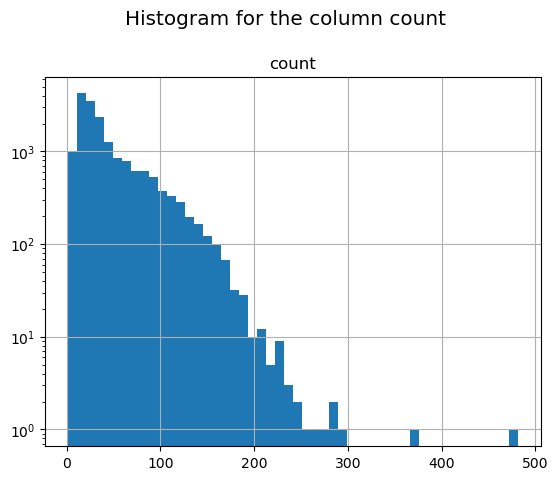

In [44]:
plot_df = tweets_fc.select('count').toPandas()

plot_df.hist(bins = 50)
plt.yscale('log')
plt.suptitle('Histogram for the column count',x=0.5, y=1.02, fontsize='x-large');

#### Accessing Metadata